# Centrality Dependence of CNM EFFECTS: npdf, eloss, p_T broadening

## Setup, Import & Preprocess

In [1]:
### npDf centrality stuffs
# --------- publication styling toggles ----------
SAVE_PDF = True
SAVE_CSV = True
ADD_MINOR_TICKS = True
ALPHA_BAND = 0.22

import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("../npdf_code")

from npdf_data   import NPDFSystem, RpAAnalysis
from npdf_data   import note_box  # for put_note, if available
from gluon_ratio import EPPS21Ratio, GluonEPPSProvider
from glauber     import OpticalGlauber, SystemSpec

from npdf_centrality import (
    compute_df49_by_centrality,
    make_centrality_weight_dict,
    bin_rpa_vs_y,
    bin_rpa_vs_pT,
    bin_rpa_vs_centrality,
)

# styling helpers
def put_note(ax, text, loc="lower right"):
    try:
        note_box(ax, text, loc=loc)
    except Exception:
        kw = dict(ha="right" if "right" in loc else "left",
                  va="bottom" if "upper" in loc else "bottom")
        xy = (0.98, 0.95) if "upper" in loc and "right" in loc else (0.02, 0.95)
        ax.text(*xy, text, transform=ax.transAxes, fontsize=10, alpha=0.9)

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
def beautify_axis(ax, xlabel=None, ylabel=None, xlim=None, ylim=None):
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if xlim:   ax.set_xlim(*xlim)
    if ylim:   ax.set_ylim(*ylim)

    # NEW: consistent major y-tick spacing (e.g. 0.2 → 0.4, 0.6, 0.8, ...)
    try:
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
    except Exception:
        pass

    if ADD_MINOR_TICKS:
        try:
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
        except Exception:
            pass
    ax.tick_params(which="both", direction="in")

# paths and constants
P5_DIR   = "../input/npdf/pPb5TeV"
P8_DIR   = "../input/npdf/pPb8TeV"
EPPS_DIR = "../input/npdf/nPDFs"
OUTDIR   = Path("./output-cnm"); OUTDIR.mkdir(exist_ok=True)

SQRTS   = { "5.02": 5023.0, "8.16": 8160.0 }
SIG_NN  = { "5.02": 67.0,   "8.16": 71.0 }

cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
Y_WINDOWS = [(-4.46,-2.96,"-4.46 < y < -2.96"),
             (-1.37,0.43,"-1.37 < y < 0.43"),
             (2.03,3.53,"2.03 < y < 3.53")]

PT_RANGE       = (0.0, 20.0)
PT_RANGE_AVG   = (0.0, 15.0)   # you can also use (1.0, 15.0) if you prefer
PT_FLOOR_W     = 1.0          # this is the “physics” floor for low-pT
Y_EDGES        = np.arange(-5.0, 5.0+0.25, 0.5)
P_EDGES        = np.arange(0.0, 15.0+2.5, 2.5)

COLORS = {"5.02":"tab:blue", "8.16":"tab:red"}
LSTYLE = {"5.02":"-",        "8.16":"--"}
DPI = 150
plt.rcParams.update({"figure.dpi":DPI, "font.size":12})

# Build providers
epps5 = GluonEPPSProvider(EPPS21Ratio(A=208,  path=EPPS_DIR),
                          sqrt_sNN_GeV=5023.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)
epps8 = GluonEPPSProvider(EPPS21Ratio(A=208,  path=EPPS_DIR),
                          sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)

gl5 = OpticalGlauber(SystemSpec("pA", SQRTS["5.02"], A=208, sigma_nn_mb=SIG_NN["5.02"]))
gl8 = OpticalGlauber(SystemSpec("pA", SQRTS["8.16"], A=208, sigma_nn_mb=SIG_NN["8.16"]))

# NPDF systems & σ_pA/σ_pp members (on common grid)
ana = RpAAnalysis()

sys5 = NPDFSystem.from_folder(P5_DIR, kick="pp", name="p+Pb 5.02 TeV")
sys8 = NPDFSystem.from_folder(P8_DIR, kick="pp", name="p+Pb 8.16 TeV")

base5, r0_5, M5 = ana.compute_rpa_members(
    sys5.df_pp, sys5.df_pa, sys5.df_errors,
    join="intersect", lowpt_policy="drop",
    pt_shift_min=PT_FLOOR_W,
    shift_if_r_below=0.0
)
base8, r0_8, M8 = ana.compute_rpa_members(
    sys8.df_pp, sys8.df_pa, sys8.df_errors,
    join="intersect", lowpt_policy="drop",
    pt_shift_min=PT_FLOOR_W,
    shift_if_r_below=0.0
)

# Weighting mode & knobs for binning
WEIGHT_MODE   = "pp@local"   # or "pa@y0", etc.
Y_REF         = 0.0
CENT_EXP_C0   = 0.25

# y-shift knob (Ramona suggestion) as fraction of Δy
Y_SHIFT_FRACTION = 2.0   # tune as you like
NB_BSAMPLES      = 5

# centrality weights for MB (w(c) scheme)
WCENT = make_centrality_weight_dict(cent_bins, c0=CENT_EXP_C0)
print("WCENT =", WCENT)

## nPDF
# build per-centrality RpA tables (5 & 8 TeV) npdf centrality dependence
df49_by_cent_5, K_by_cent_5, SA_all_5, Y_SHIFT_5 = compute_df49_by_centrality(
    base5, r0_5, M5, epps5, gl5, cent_bins,
    nb_bsamples=NB_BSAMPLES,
    y_shift_fraction=Y_SHIFT_FRACTION,
)
df49_by_cent_8, K_by_cent_8, SA_all_8, Y_SHIFT_8 = compute_df49_by_centrality(
    base8, r0_8, M8, epps8, gl8, cent_bins,
    nb_bsamples=NB_BSAMPLES,
    y_shift_fraction=Y_SHIFT_FRACTION,
)

energy_ctx = {
    "5.02": dict(df49_by_cent=df49_by_cent_5,
                 df_pp=sys5.df_pp,
                 df_pa=sys5.df_pa,
                 gluon=epps5),
    "8.16": dict(df49_by_cent=df49_by_cent_8,
                 df_pp=sys8.df_pp,
                 df_pa=sys8.df_pa,
                 gluon=epps8),
}
ACTIVE_ENERGIES = ["5.02", "8.16"]

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7718.37 mb, σ_tot^pA ≈ 1909.03 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb
WCENT = {'0-20%': 0.5609451038411363, '20-40%': 0.25204888243556506, '40-60%': 0.11325286325167577, '60-80%': 0.050887791728184854, '80-100%': 0.022865358743438213}


In [2]:

## eloss and pT broadening setup
import sys, os, math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace
import torch

sys.path.append("../eloss_code")

from particle  import Particle
from glauber   import SystemSpec, OpticalGlauber
from coupling  import alpha_s_provider
import quenching_fast as QF

# NEW: import module
from eloss_cronin_centrality import (
    rpa_band_vs_y,
    rpa_band_vs_pT,
    rpa_band_vs_centrality,
    plot_RpA_vs_y_components_per_centrality,
    plot_RpA_vs_pT_components_per_centrality,
    plot_RpA_vs_centrality_components_band,
    make_centrality_weight_dict,   # if you want explicit weights
)

roots5, roots8   = 5023.0, 8160.0
sigma_nn_5, sigma_nn_8 = 67.6, 71.0
A = 208
device = "cuda" if (QF._HAS_TORCH and torch.cuda.is_available()) else "cpu"

P_charmonia  = Particle(family="charmonia",  state="avg")
P_bottomonia = Particle(family="bottomonia", state="avg")

alpha_running = alpha_s_provider(mode="running",  LambdaQCD=0.25)
alpha_cst = alpha_s_provider(mode="constant", alpha0=0.5)
# alpha_s   = alpha_cst
alpha_s   = alpha_running

gl5 = OpticalGlauber(SystemSpec("pA", roots5, A=A, sigma_nn_mb=sigma_nn_5))
gl8 = OpticalGlauber(SystemSpec("pA", roots8, A=A, sigma_nn_mb=sigma_nn_8))

Lmb_5 = gl5.leff_minbias_pA()
Lmb_8 = gl8.leff_minbias_pA()

cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
RAPIDITY_WINDOWS   = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]
Q0_PAIR = (0.05, 0.09)

QP5_base = QF.QuenchParams(
    qhat0        = 0.075,
    lp_fm        = 1.5,
    LA_fm        = Lmb_5,
    LB_fm        = Lmb_5,
    lambdaQCD    = 0.25,
    roots_GeV    = roots5,
    alpha_of_mu  = alpha_s,
    alpha_scale  = "mT",
    use_hard_cronin = True,
    mapping      = "exp",
    device       = device,
)
QP8_base = replace(QP5_base,
                   roots_GeV = roots8,
                   LA_fm     = Lmb_8,
                   LB_fm     = Lmb_8)

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7724.42 mb, σ_tot^pA ≈ 1911.63 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- choose which energy to combine ----
CNM_ENERGY = "8.16" #"8.16"  or "5.02" 

# Map energy → roots, Glauber, quench params, npdf context
if CNM_ENERGY == "5.02":
    roots_cnm  = SQRTS["5.02"]
    gl_cnm     = gl5          # from eloss setup
    qp_base_cnm = QP5_base
    npdf_ctx    = energy_ctx["5.02"]
elif CNM_ENERGY == "8.16":
    roots_cnm  = SQRTS["8.16"]
    gl_cnm     = gl8
    qp_base_cnm = QP8_base
    npdf_ctx    = energy_ctx["8.16"]
else:
    raise ValueError("CNM_ENERGY must be '5.02' or '8.16'")

# Nice labels
CNM_LABEL = rf"$\sqrt{{s_{{NN}}}}={roots_cnm/1000:.2f}\,\mathrm{{TeV}},\;\psi$"

# ---- small helpers ----

def step_from_centers(x_cent, vals):
    """
    Build (x_edges, y_step) so that plt.step(..., where='post')
    shows flat segments per bin, assuming uniform spacing.
    """
    x_cent = np.asarray(x_cent, float)
    vals   = np.asarray(vals, float)
    assert x_cent.size == vals.size

    if x_cent.size > 1:
        dx = np.diff(x_cent)
        dx0 = dx[0]
        if not np.allclose(dx, dx0):
            raise ValueError("x_cent not uniformly spaced")
    else:
        dx0 = 1.0

    x_edges = np.concatenate(([x_cent[0] - 0.5*dx0],
                              x_cent + 0.5*dx0))
    y_step  = np.concatenate([vals, vals[-1:]])
    return x_edges, y_step


def combine_two_bands_1d(R1_c, R1_lo, R1_hi,
                         R2_c, R2_lo, R2_hi,
                         eps=1e-12):
    """
    Factorised combination for arrays:

      R_tot = R1 * R2
      (δR_tot / R_tot)^2 = (δR1 / R1)^2 + (δR2 / R2)^2.

    Works elementwise, returns (Rc, Rlo, Rhi).
    """
    R1_c  = np.asarray(R1_c,  float)
    R1_lo = np.asarray(R1_lo, float)
    R1_hi = np.asarray(R1_hi, float)
    R2_c  = np.asarray(R2_c,  float)
    R2_lo = np.asarray(R2_lo, float)
    R2_hi = np.asarray(R2_hi, float)

    # start with NaNs everywhere, only fill where both are finite
    Rc   = np.full_like(R1_c,  np.nan, dtype=float)
    Rlo  = np.full_like(R1_c,  np.nan, dtype=float)
    Rhi  = np.full_like(R1_c,  np.nan, dtype=float)

    mask = np.isfinite(R1_c) & np.isfinite(R2_c)
    if not np.any(mask):
        return Rc, Rlo, Rhi

    d1 = 0.5 * np.abs(R1_hi - R1_lo)
    d2 = 0.5 * np.abs(R2_hi - R2_lo)

    R_tot_c = R1_c * R2_c
    R1_safe = np.where(np.abs(R1_c) > eps, R1_c, 1.0)
    R2_safe = np.where(np.abs(R2_c) > eps, R2_c, 1.0)

    rel2 = (d1 / R1_safe)**2 + (d2 / R2_safe)**2
    d_tot = np.abs(R_tot_c) * np.sqrt(rel2)

    Rc[mask]  = R_tot_c[mask]
    Rlo[mask] = R_tot_c[mask] - d_tot[mask]
    Rhi[mask] = R_tot_c[mask] + d_tot[mask]
    return Rc, Rlo, Rhi

In [4]:
# Component styles for combined plots
COMP_COLORS = {
    "npdf":        "tab:blue",
    "eloss":       "tab:orange",
    "broad":       "tab:green",
    "eloss_broad": "tab:purple",
    "cnm":         "k",
}
COMP_STYLES = {
    "npdf":        "-",
    "eloss":       "-",
    "broad":       "-",
    "eloss_broad": "-",
    "cnm":         "-",
}
COMP_LABELS = {
    "npdf":        "nPDF",
    "eloss":       "eloss",
    "broad":       r"$p_T$ broad",
    "eloss_broad": r"eloss $\times p_T$ broad",
    "cnm":         r"CNM",
}

## $R_{pA}$ vs $y$

In [5]:
## npdf vs y
bins_vs_y = {}
for E in ACTIVE_ENERGIES:
    ctx = energy_ctx[E]
    bins_vs_y[E] = bin_rpa_vs_y(
        ctx["df49_by_cent"],
        ctx["df_pp"],
        ctx["df_pa"],
        ctx["gluon"],
        cent_bins=cent_bins,
        y_edges=Y_EDGES,
        pt_range_avg=PT_RANGE_AVG,
        weight_mode=WEIGHT_MODE,
        y_ref=Y_REF,
        pt_floor_w=PT_FLOOR_W,
        wcent_dict=WCENT,
        include_mb=True,
    )

In [6]:
# ---------- nPDF RpA(y) for chosen energy ----------
npdf_bins_y = bins_vs_y[CNM_ENERGY]        # already computed earlier
tags_y      = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]

# define bin centers for y (common for all components)
y_cent = 0.5 * (Y_EDGES[:-1] + Y_EDGES[1:])

# ---------- eloss + broad bands vs y ----------
y_cent_eloss, bands_y, labels_y = rpa_band_vs_y(
    P_charmonia, roots_cnm, qp_base_cnm,
    gl_cnm, cent_bins,
    Y_EDGES, PT_RANGE_AVG,
    components=("loss", "broad", "total"),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
    table_for_pp=None,
    mb_weight_mode="exp",
    mb_c0=CENT_EXP_C0,
    mb_weights_custom=None,
)
assert np.allclose(y_cent, y_cent_eloss)

RL_c, RL_lo, RL_hi = bands_y["loss"]
RB_c, RB_lo, RB_hi = bands_y["broad"]
RT_c, RT_lo, RT_hi = bands_y["total"]    # eloss × broad

# ---------- build combined CNM bands vs y ----------
cnm_vs_y = {
    "npdf":        {},
    "eloss":       {},
    "broad":       {},
    "eloss_broad": {},
    "cnm":         {},
}

for tag in tags_y:
    # --- nPDF band from npdf_centrality ---
    npdf_data = npdf_bins_y[tag]
    Rn_c  = npdf_data["r_central"]
    Rn_lo = npdf_data["r_lo"]
    Rn_hi = npdf_data["r_hi"]

    # --- eloss / broad / total (eloss×broad) from eloss_cronin_centrality ---
    Rloss_c  = RL_c[tag]
    Rloss_lo = RL_lo[tag]
    Rloss_hi = RL_hi[tag]

    Rb_c  = RB_c[tag]
    Rb_lo = RB_lo[tag]
    Rb_hi = RB_hi[tag]

    Rtot_c  = RT_c[tag]
    Rtot_lo = RT_lo[tag]
    Rtot_hi = RT_hi[tag]

    # --- combined CNM = nPDF × (eloss×broad) in quadrature ---
    Rcnm_c, Rcnm_lo, Rcnm_hi = combine_two_bands_1d(
        Rn_c, Rn_lo, Rn_hi,
        Rtot_c, Rtot_lo, Rtot_hi,
    )

    cnm_vs_y["npdf"][tag]        = (Rn_c, Rn_lo, Rn_hi)
    cnm_vs_y["eloss"][tag]       = (Rloss_c, Rloss_lo, Rloss_hi)
    cnm_vs_y["broad"][tag]       = (Rb_c, Rb_lo, Rb_hi)
    cnm_vs_y["eloss_broad"][tag] = (Rtot_c, Rtot_lo, Rtot_hi)
    cnm_vs_y["cnm"][tag]         = (Rcnm_c, Rcnm_lo, Rcnm_hi)

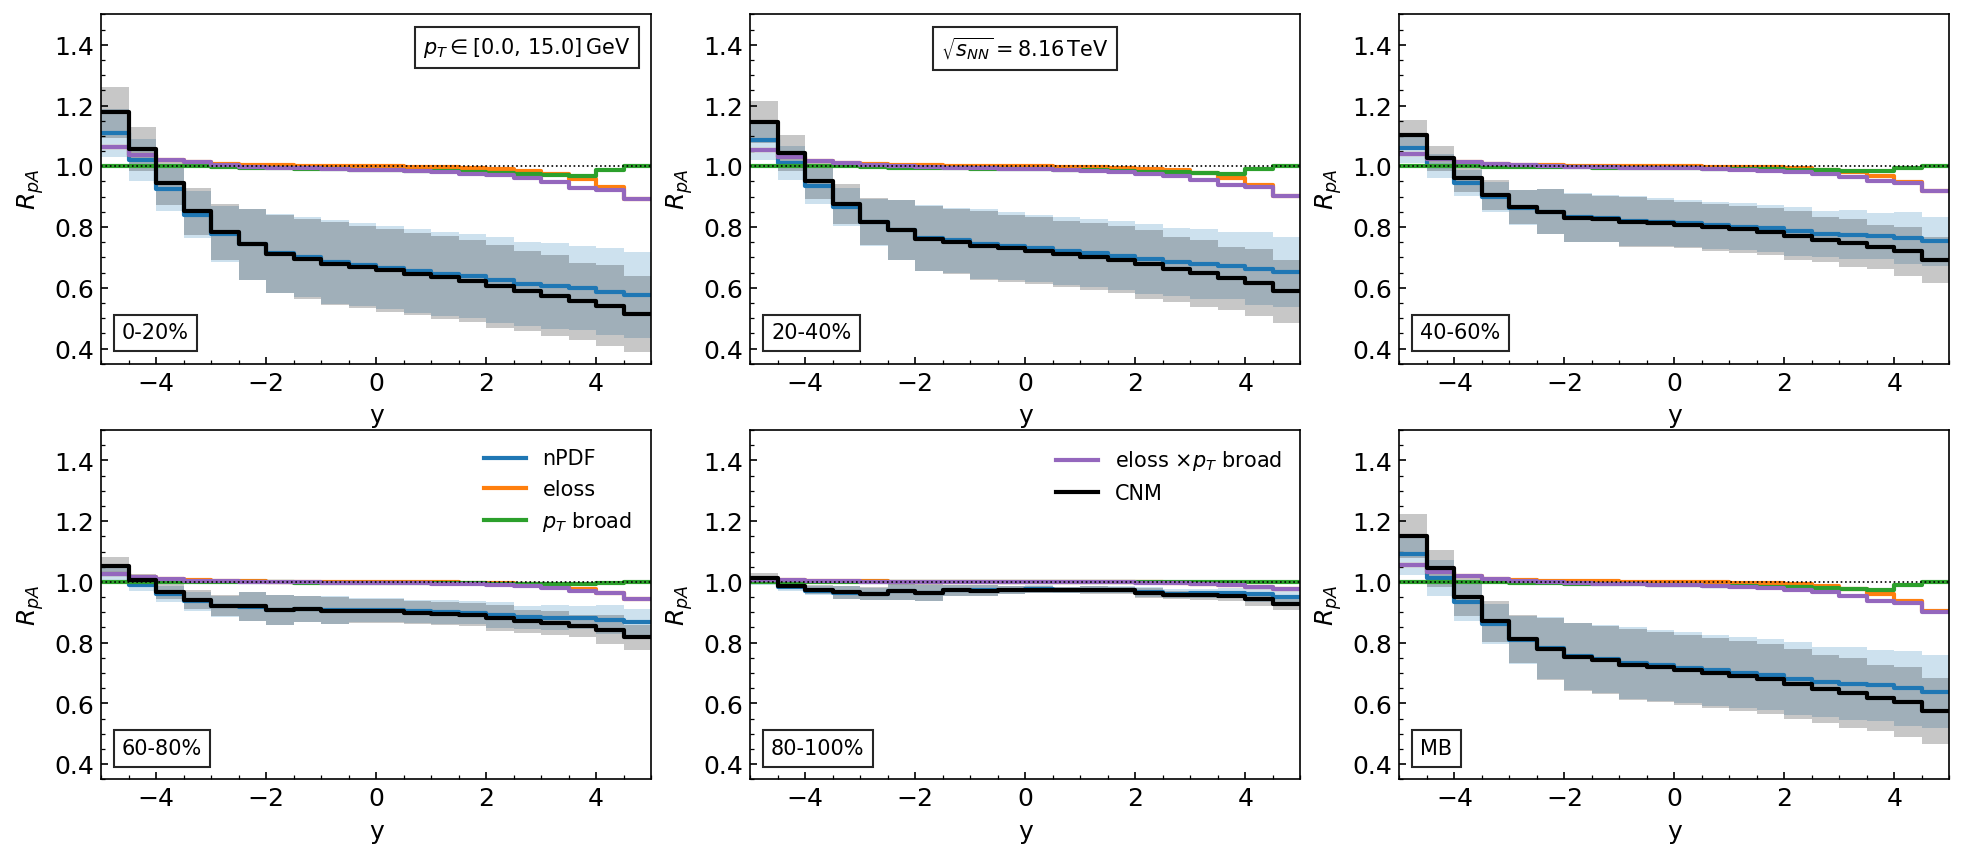

In [7]:
# ---------- publication-style plot: RpA(y) with all components ----------
Y_NCOLS = 3
n_pan   = len(tags_y)
n_rows  = int(np.ceil(n_pan / Y_NCOLS))
n_cols  = Y_NCOLS

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(5.3*n_cols, 3.0*n_rows),
    dpi=DPI, sharex=False, sharey=False,
)
axes = np.atleast_1d(axes).ravel()

handles_, labels_ = [], []

for ip, tag in enumerate(tags_y):
    ax = axes[ip]

    for comp in ["npdf", "eloss", "broad", "eloss_broad", "cnm"]:
        Rc, Rlo, Rhi = cnm_vs_y[comp][tag]

        col = COMP_COLORS[comp]
        # solid coloured line for all components
        ls  = "-"
        lab = COMP_LABELS[comp] if (ip == 0) else None  # legend labels only once

        x_edges, y_c  = step_from_centers(y_cent, Rc)
        _,       y_lo = step_from_centers(y_cent, Rlo)
        _,       y_hi = step_from_centers(y_cent, Rhi)

        ln, = ax.step(
            x_edges, y_c,
            where="post",
            color=col, ls=ls, lw=2.0,
            label=lab,
        )
        ax.fill_between(
            x_edges, y_lo, y_hi,
            step="post",
            color=col, alpha=ALPHA_BAND, linewidth=0.0,
        )

        if lab is not None:
            handles_.append(ln)
            labels_.append(lab)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)

    beautify_axis(
        ax,
        xlabel="y",
        ylabel=r"$R_{pA}$",
        xlim=(Y_EDGES[0], Y_EDGES[-1]),
        ylim=(0.35, 1.50),
    )
    put_note(ax, tag, loc="lower left")

for k in range(n_pan, len(axes)):
    fig.delaxes(axes[k])

# ---------- legends split between 4th and 5th subplots ----------
uniq = {}
for h, l in zip(handles_, labels_):
    uniq[l] = h

legend_handles = list(uniq.values())
legend_labels  = list(uniq.keys())
n_leg = len(legend_handles)

if n_leg > 0:
    # split roughly half: first half (ceil) in 4th, rest in 5th
    mid = (n_leg + 1) // 2
    handles_4 = legend_handles[:mid]
    labels_4  = legend_labels[:mid]
    handles_5 = legend_handles[mid:]
    labels_5  = legend_labels[mid:]

    # 4th subplot (index 3)
    if n_pan > 3 and len(handles_4) > 0:
        axes[3].legend(
            handles_4, labels_4,
            loc="upper right", frameon=False, fontsize=10,
        )

    # 5th subplot (index 4)
    if n_pan > 4 and len(handles_5) > 0:
        axes[4].legend(
            handles_5, labels_5,
            loc="upper right", frameon=False, fontsize=10,
        )

# ---------- put energy, pT info in panels (no fig title) ----------
energy_note = rf"$\sqrt{{s_{{NN}}}}={roots_cnm/1000:.2f}\,\mathrm{{TeV}}$"
pty_note    = rf"$p_T\in[{PT_RANGE_AVG[0]},\,{PT_RANGE_AVG[1]}]\,\mathrm{{GeV}}$"

ref_ax = axes[0]
put_note(axes[1], energy_note, loc="upper center")
put_note(ref_ax,  pty_note,    loc="upper right")

plt.subplots_adjust(top=0.96, hspace=0.19, wspace=0.18)

if SAVE_PDF:
    fig.savefig(
        OUTDIR / f"RpA_CNM_vs_y_{CNM_ENERGY.replace('.','p')}TeV.pdf",
        bbox_inches="tight",
    )
plt.show()

## $R_{pA}$ vs $p_T$

In [8]:
## npdf vs pT
bins_vs_pT = {E: {} for E in ACTIVE_ENERGIES}
for E in ACTIVE_ENERGIES:
    ctx = energy_ctx[E]
    for (y0, y1, name) in Y_WINDOWS:
        bins_vs_pT[E][name] = bin_rpa_vs_pT(
            ctx["df49_by_cent"],
            ctx["df_pp"],
            ctx["df_pa"],
            ctx["gluon"],
            cent_bins=cent_bins,
            pt_edges=P_EDGES,
            y_window=(y0, y1),
            weight_mode=WEIGHT_MODE,
            y_ref=Y_REF,
            pt_floor_w=PT_FLOOR_W,
            wcent_dict=WCENT,
            include_mb=True,
        )

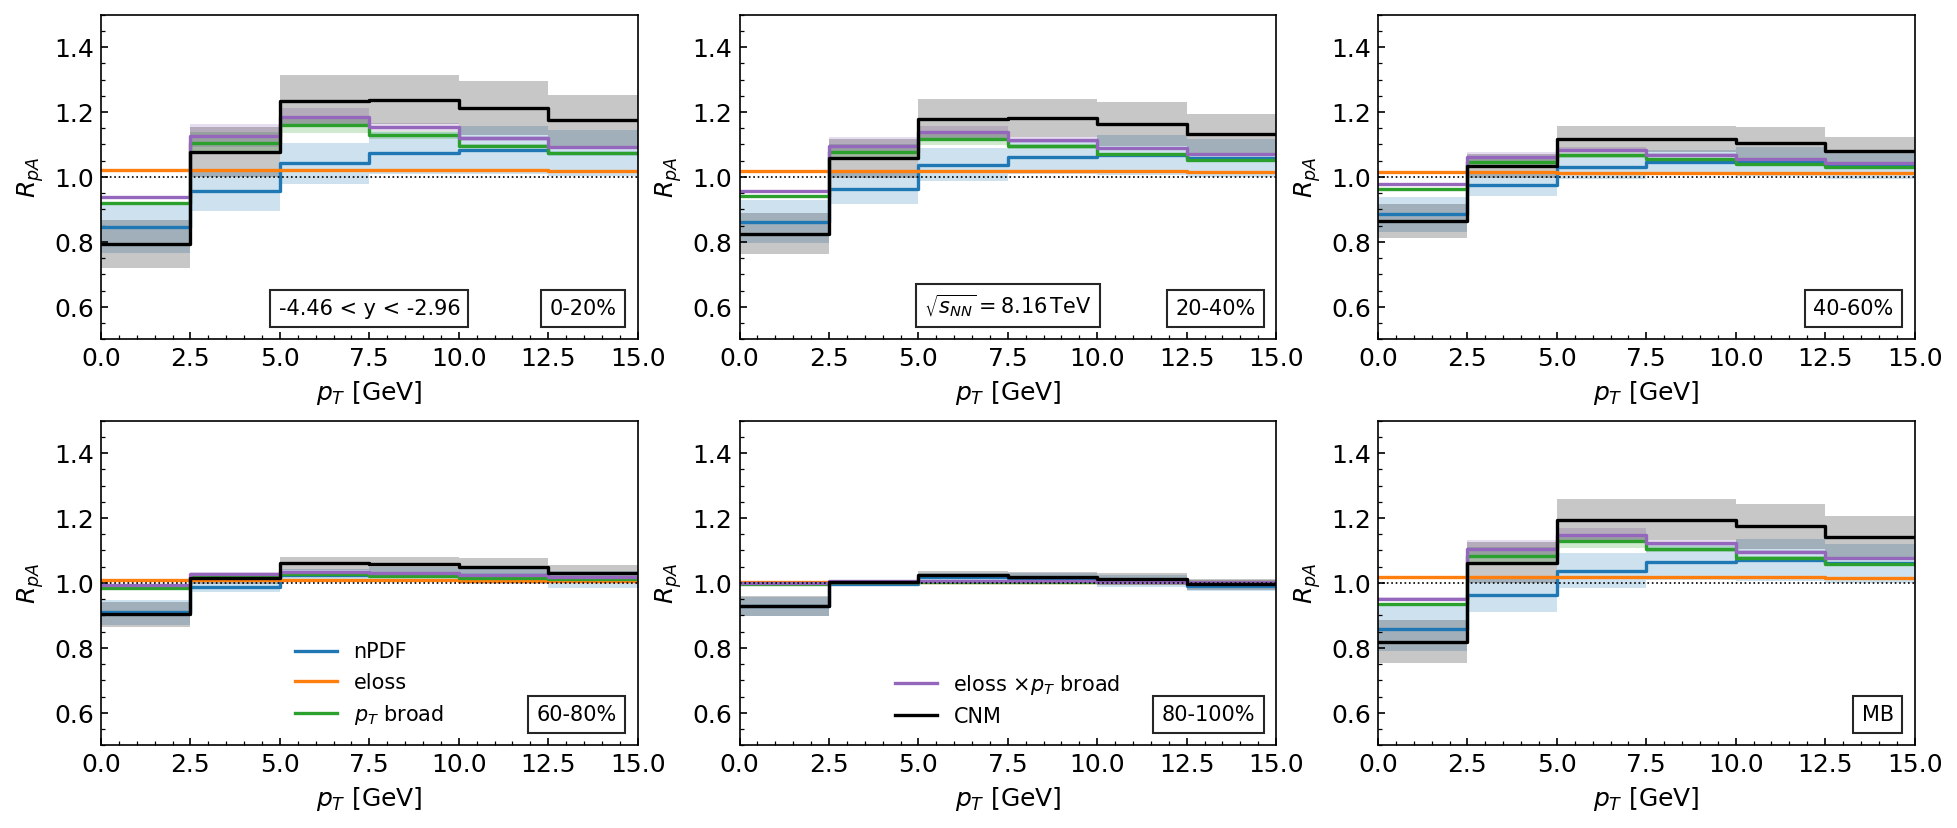

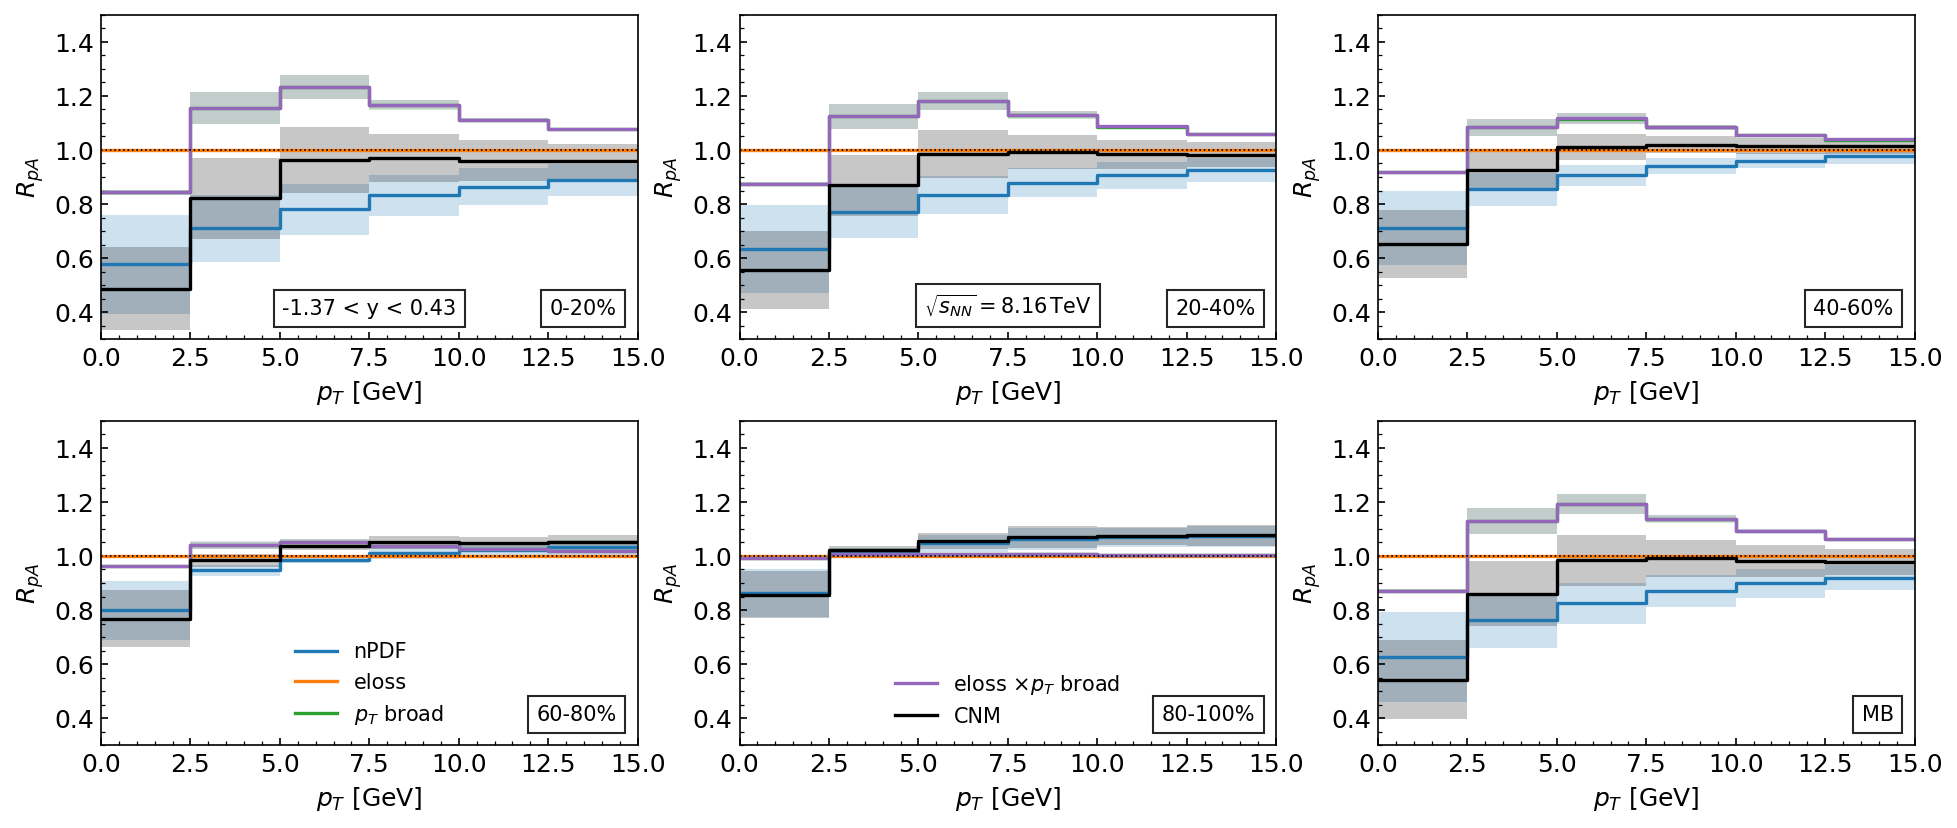

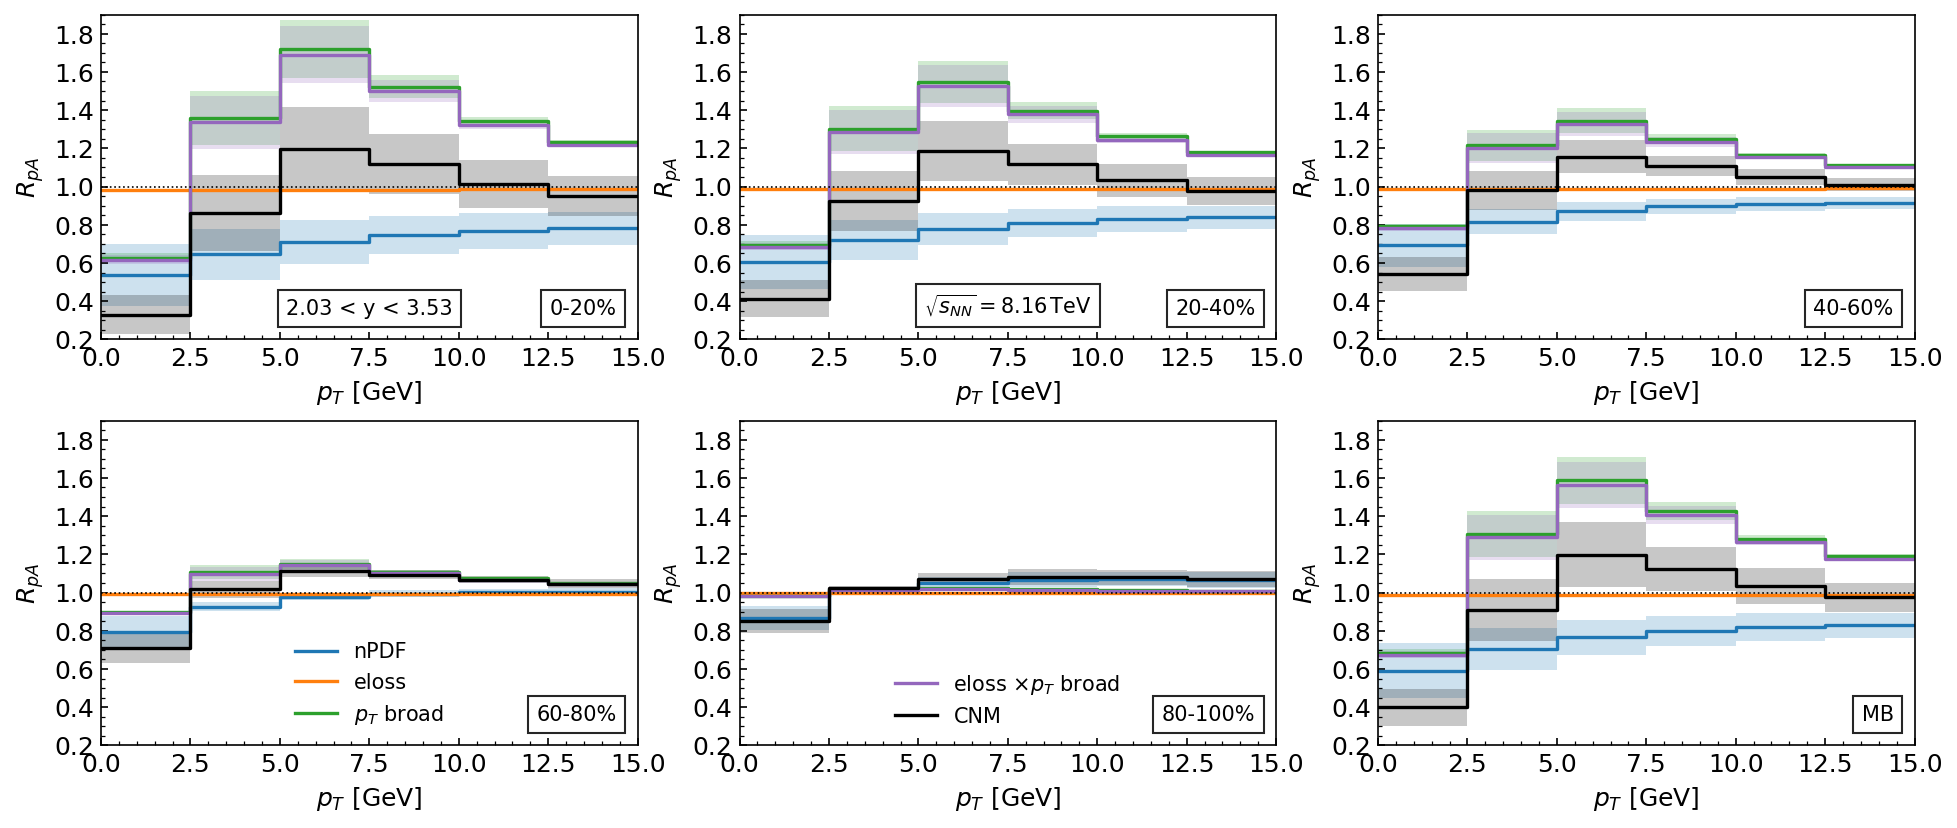

In [9]:
cnm_vs_pT = {}   # cnm_vs_pT[window_name][comp][tag] = (Rc,Rlo,Rhi)

# NEW: per-y-window y-limits
YLIMS_PT = {
    Y_WINDOWS[0][2]: (0.5, 1.50),  # backward
    Y_WINDOWS[1][2]: (0.3, 1.50),  # central
    Y_WINDOWS[2][2]: (0.2, 1.90),  # forward
}

for (y0, y1, name) in Y_WINDOWS:
    # --- nPDF bins vs pT (already computed earlier) ---
    npdf_bins_pt = bins_vs_pT[CNM_ENERGY][name]

    # --- eloss + broad bands vs pT in this rapidity window ---
    pT_cent, bands_pt, labels_pt = rpa_band_vs_pT(
        P_charmonia, roots_cnm, qp_base_cnm,
        gl_cnm, cent_bins,
        P_EDGES, (y0, y1),
        components=("loss", "broad", "total"),
        q0_pair=Q0_PAIR,
        p0_scale_pair=(0.9, 1.1),
        Ny_bin=12, Npt_bin=24,
        weight_kind="pp",
        weight_ref_y="local",
        mb_weight_mode="exp",
        mb_c0=CENT_EXP_C0,
        mb_weights_custom=None,
    )

    RL_c, RL_lo, RL_hi = bands_pt["loss"]
    RB_c, RB_lo, RB_hi = bands_pt["broad"]
    RT_c, RT_lo, RT_hi = bands_pt["total"]

    tags_pt = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]

    cnm_vs_pT[name] = {
        "npdf":        {},
        "eloss":       {},
        "broad":       {},
        "eloss_broad": {},
        "cnm":         {},
    }

    for tag in tags_pt:
        # nPDF from npdf_centrality
        d = npdf_bins_pt[tag]
        Rn_c  = d["r_central"]
        Rn_lo = d["r_lo"]
        Rn_hi = d["r_hi"]

        # eloss/broad/total from eloss_cronin_centrality
        Rloss_c  = RL_c[tag]
        Rloss_lo = RL_lo[tag]
        Rloss_hi = RL_hi[tag]

        Rb_c  = RB_c[tag]
        Rb_lo = RB_lo[tag]
        Rb_hi = RB_hi[tag]

        Rtot_c  = RT_c[tag]
        Rtot_lo = RT_lo[tag]
        Rtot_hi = RT_hi[tag]

        Rcnm_c, Rcnm_lo, Rcnm_hi = combine_two_bands_1d(
            Rn_c, Rn_lo, Rn_hi,
            Rtot_c, Rtot_lo, Rtot_hi,
        )

        cnm_vs_pT[name]["npdf"][tag]        = (Rn_c, Rn_lo, Rn_hi)
        cnm_vs_pT[name]["eloss"][tag]       = (Rloss_c, Rloss_lo, Rloss_hi)
        cnm_vs_pT[name]["broad"][tag]       = (Rb_c, Rb_lo, Rb_hi)
        cnm_vs_pT[name]["eloss_broad"][tag] = (Rtot_c, Rtot_lo, Rtot_hi)
        cnm_vs_pT[name]["cnm"][tag]         = (Rcnm_c, Rcnm_lo, Rcnm_hi)

    # ---------- plot panels for this y-window ----------
    tags_pt = [f"{a}-{b}%" for (a,b) in cent_bins] + ["MB"]
    n_pan   = len(tags_pt)
    ncols   = 3
    nrows   = int(np.ceil(n_pan / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5.2*ncols, 2.9*nrows),
        dpi=DPI, sharex=False, sharey=False,
    )
    axes = np.atleast_1d(axes).ravel()

    handles_, labels_ = [], []

    # choose y-limits for this y-window
    ylim_pt = YLIMS_PT.get(name, (0.30, 1.50))

    for ip, tag in enumerate(tags_pt):
        ax = axes[ip]

        for comp in ["npdf", "eloss", "broad", "eloss_broad", "cnm"]:
            Rc, Rlo, Rhi = cnm_vs_pT[name][comp][tag]

            col = COMP_COLORS[comp]
            ls  = COMP_STYLES[comp]
            lab = COMP_LABELS[comp] if (ip == 0) else None

            x_edges, y_c  = step_from_centers(pT_cent, Rc)
            _,       y_lo = step_from_centers(pT_cent, Rlo)
            _,       y_hi = step_from_centers(pT_cent, Rhi)

            ln, = ax.step(
                x_edges, y_c,
                where="post",
                color=col, ls=ls, lw=1.6,
                label=lab,
            )
            ax.fill_between(
                x_edges, y_lo, y_hi,
                step="post",
                color=col, alpha=ALPHA_BAND, linewidth=0.0,
            )

            if lab is not None:
                handles_.append(ln)
                labels_.append(lab)

        ax.axhline(1.0, color="k", ls=":", lw=0.8)

        beautify_axis(
            ax,
            xlabel=r"$p_T$ [GeV]",
            ylabel=r"$R_{pA}$",
            xlim=(P_EDGES[0], P_EDGES[-1]),
            ylim=ylim_pt,   # <-- per-window y-limits
        )

        # centrality label in lower-right of each subfigure
        put_note(ax, tag, loc="lower right")

    # remove unused axes
    for k in range(n_pan, len(axes)):
        fig.delaxes(axes[k])

    # y-range label (once) in lower-left of first panel
    put_note(axes[0], name, loc="lower center")

    # legends inside two subfigures (e.g. 4th & 5th) instead of fig-level legend
    uniq = {}
    for h, l in zip(handles_, labels_):
        uniq[l] = h
    legend_handles = list(uniq.values())
    legend_labels  = list(uniq.keys())
    n_leg = len(legend_handles)

    if n_leg > 0:
        mid = (n_leg + 1) // 2
        handles_1 = legend_handles[:mid]
        labels_1  = legend_labels[:mid]
        handles_2 = legend_handles[mid:]
        labels_2  = legend_labels[mid:]

        # Put legends into two subfigures (4th and 5th panels if they exist)
        if n_pan > 3 and len(handles_1) > 0:
            axes[3].legend(
                handles_1, labels_1,
                loc="lower center", frameon=False, fontsize=10,
            )
        if n_pan > 4 and len(handles_2) > 0:
            axes[4].legend(
                handles_2, labels_2,
                loc="lower center", frameon=False, fontsize=10,
            )

    # energy (no ψ) in lower center of second panel (as you had)
    energy_note_pt = rf"$\sqrt{{s_{{NN}}}}={roots_cnm/1000:.2f}\,\mathrm{{TeV}}$"
    put_note(axes[1], energy_note_pt, loc="lower center")

    # no fig.suptitle, no pT-range note
    plt.subplots_adjust(top=0.95, hspace=0.25, wspace=0.19)

    if SAVE_PDF:
        fig.savefig(
            OUTDIR / f"RpA_CNM_vs_pT_{name.replace(' ','_')}_{CNM_ENERGY.replace('.','p')}TeV.pdf",
            bbox_inches="tight",
        )
    plt.show()

## $R_{pA}$ vs Centrality

In [10]:
## npdf VS centrality
bins_vs_cent = {E: {} for E in ACTIVE_ENERGIES}
for E in ACTIVE_ENERGIES:
    ctx = energy_ctx[E]
    for (y0, y1, name) in Y_WINDOWS:
        bins_vs_cent[E][name] = bin_rpa_vs_centrality(
            ctx["df49_by_cent"],
            ctx["df_pp"],
            ctx["df_pa"],
            ctx["gluon"],
            cent_bins=cent_bins,
            y_window=(y0, y1),
            pt_range_avg=PT_RANGE_AVG,
            weight_mode=WEIGHT_MODE,
            y_ref=Y_REF,
            pt_floor_w=PT_FLOOR_W,
        )

# Exponential centrality weights for MB (same c0 as before)
WCENT_EXP = make_centrality_weight_dict(cent_bins, c0=CENT_EXP_C0)
width_weights_exp = np.array(
    [WCENT_EXP[f"{a}-{b}%"] for (a,b) in cent_bins],
    float,
)

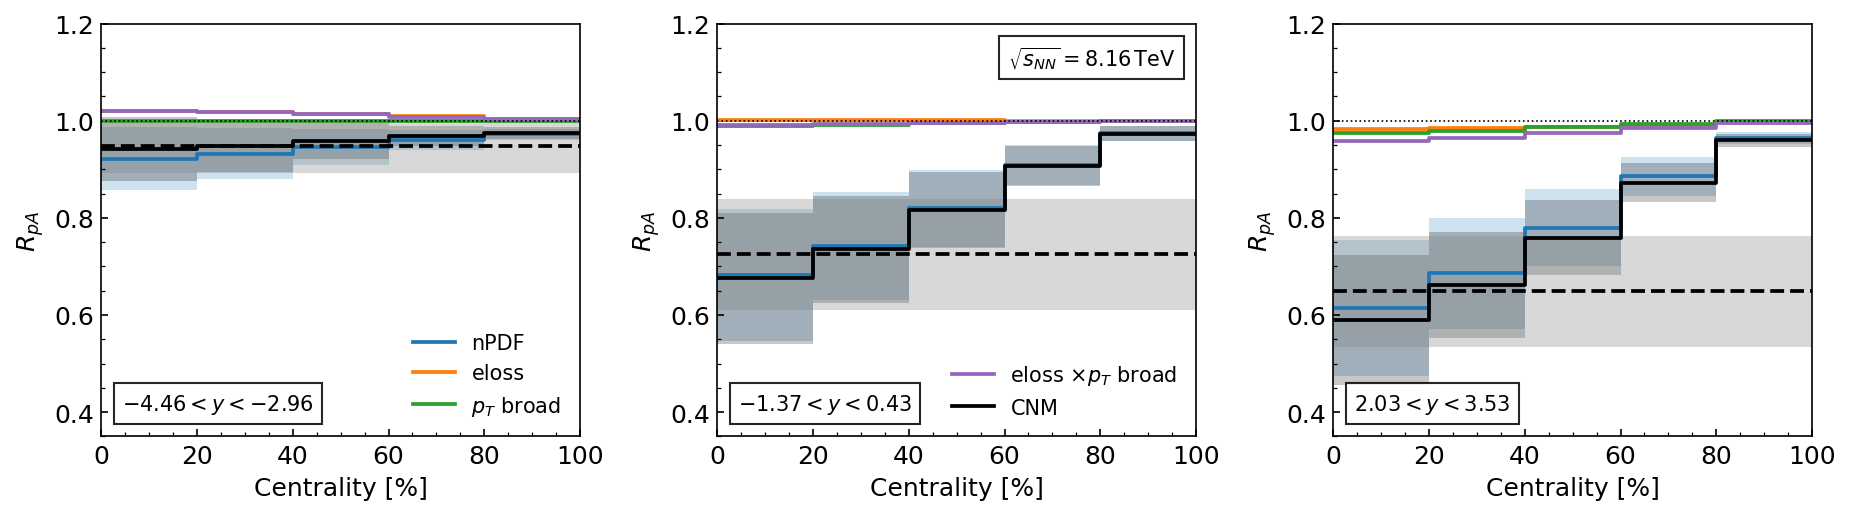

In [11]:
cnm_vs_cent = {}   # cnm_vs_cent[name][comp] = dict with arrays

fig, axes = plt.subplots(1, 3, figsize=(12.5,3.6), dpi=DPI, sharey=False)
axes = np.atleast_1d(axes).ravel()

# collect legend handles/labels once
handles_, labels_ = [], []

for ax, (y0, y1, name) in zip(axes, Y_WINDOWS):

    # ----- nPDF vs centrality with exponential MB weights -----
    npdf_cent = bin_rpa_vs_centrality(
        npdf_ctx["df49_by_cent"],
        npdf_ctx["df_pp"],
        npdf_ctx["df_pa"],
        npdf_ctx["gluon"],
        cent_bins=cent_bins,
        y_window=(y0, y1),
        pt_range_avg=PT_RANGE_AVG,
        weight_mode=WEIGHT_MODE,
        y_ref=Y_REF,
        pt_floor_w=PT_FLOOR_W,
        width_weights=width_weights_exp,
    )

    cL   = npdf_cent["cent_left"]
    cR   = npdf_cent["cent_right"]
    Rc_n = npdf_cent["r_central"]
    Rlo_n = npdf_cent["r_lo"]
    Rhi_n = npdf_cent["r_hi"]

    mb_n_c  = npdf_cent["mb_r_central"]
    mb_n_lo = npdf_cent["mb_r_lo"]
    mb_n_hi = npdf_cent["mb_r_hi"]

    labels_cent = [f"{int(a)}-{int(b)}%" for (a,b) in cent_bins]

    # ----- eloss / broad / total vs centrality -----
    (labels_el,
     RL_c, RL_lo, RL_hi,
     RB_c, RB_lo, RB_hi,
     RT_c, RT_lo, RT_hi,
     RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
         P_charmonia, roots_cnm, qp_base_cnm,
         gl_cnm, cent_bins,
         (y0, y1), PT_RANGE_AVG,
         q0_pair=Q0_PAIR,
         p0_scale_pair=(0.9, 1.1),
         Ny_bin=16, Npt_bin=32,
         weight_kind="pp",
         weight_ref_y="local",
         mb_weight_mode="exp",
         mb_c0=CENT_EXP_C0,
         mb_weights_custom=None,
    )
    assert labels_el == labels_cent

    # convert RL/RB/RT dicts → arrays in the correct order
    Rloss_c  = np.array([RL_c[lab]  for lab in labels_cent])
    Rloss_lo = np.array([RL_lo[lab] for lab in labels_cent])
    Rloss_hi = np.array([RL_hi[lab] for lab in labels_cent])

    Rb_c  = np.array([RB_c[lab]  for lab in labels_cent])
    Rb_lo = np.array([RB_lo[lab] for lab in labels_cent])
    Rb_hi = np.array([RB_hi[lab] for lab in labels_cent])

    Rtot_c  = np.array([RT_c[lab]  for lab in labels_cent])
    Rtot_lo = np.array([RT_lo[lab] for lab in labels_cent])
    Rtot_hi = np.array([RT_hi[lab] for lab in labels_cent])

    # ----- CNM = nPDF × total(eloss×broad) -----
    Rcnm_c, Rcnm_lo, Rcnm_hi = combine_two_bands_1d(
        Rc_n, Rlo_n, Rhi_n,
        Rtot_c, Rtot_lo, Rtot_hi,
    )

    # MB for eloss×broad (from RMB_tot) and nPDF
    Rc_tot_MB, Rlo_tot_MB, Rhi_tot_MB = RMB_tot

    Rcnm_MB_c, Rcnm_MB_lo, Rcnm_MB_hi = combine_two_bands_1d(
        np.array([mb_n_c]),
        np.array([mb_n_lo]),
        np.array([mb_n_hi]),
        np.array([Rc_tot_MB]),
        np.array([Rlo_tot_MB]),
        np.array([Rhi_tot_MB]),
    )
    Rcnm_MB_c  = float(Rcnm_MB_c[0])
    Rcnm_MB_lo = float(Rcnm_MB_lo[0])
    Rcnm_MB_hi = float(Rcnm_MB_hi[0])

    cnm_vs_cent[name] = {
        "npdf":        (Rc_n,   Rlo_n,   Rhi_n,   mb_n_c,  mb_n_lo,  mb_n_hi),
        "eloss":       (Rloss_c, Rloss_lo, Rloss_hi, *RMB_loss),
        "broad":       (Rb_c,    Rb_lo,   Rb_hi,   *RMB_broad),
        "eloss_broad": (Rtot_c,  Rtot_lo, Rtot_hi, Rc_tot_MB, Rlo_tot_MB, Rhi_tot_MB),
        "cnm":         (Rcnm_c,  Rcnm_lo, Rcnm_hi, Rcnm_MB_c, Rcnm_MB_lo, Rcnm_MB_hi),
    }

    # ----- plotting: step vs centrality for all components -----
    def cent_step_arrays(vals):
        vals = np.asarray(vals, float)
        edges = [cent_bins[0][0]] + [b for (_, b) in cent_bins]
        x_edges = np.array(edges, float)
        y_step  = np.concatenate([vals, vals[-1:]])
        return x_edges, y_step

    for comp in ["npdf", "eloss", "broad", "eloss_broad", "cnm"]:
        Rc, Rlo, Rhi, Rc_MB, Rlo_MB, Rhi_MB = cnm_vs_cent[name][comp]

        col = COMP_COLORS[comp]
        ls  = COMP_STYLES[comp]
        lab = COMP_LABELS[comp] if (ax is axes[0]) else None

        x_edges, y_c  = cent_step_arrays(Rc)
        _,       y_lo = cent_step_arrays(Rlo)
        _,       y_hi = cent_step_arrays(Rhi)

        ln, = ax.step(
            x_edges, y_c,
            where="post",
            lw=1.8,
            color=col, ls=ls,
            label=lab,
        )
        ax.fill_between(
            x_edges, y_lo, y_hi,
            step="post",
            color=col, alpha=ALPHA_BAND, linewidth=0.0,
        )

        # MB band (only strong for CNM, lighter for others)
        if comp == "cnm":
            x_mb = np.array([cent_bins[0][0], cent_bins[-1][1]], float)
            ax.hlines(Rc_MB, x_mb[0], x_mb[1],
                      colors="k", linestyles="--", linewidth=1.8)
            ax.fill_between(
                x_mb,
                [Rlo_MB, Rlo_MB],
                [Rhi_MB, Rhi_MB],
                color="gray", alpha=0.30, linewidth=0.0,
            )

        # collect legend entries, but don't draw per-panel legend
        if lab is not None:
            handles_.append(ln)
            labels_.append(lab)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    beautify_axis(
        ax,
        xlabel="Centrality [%]",
        ylabel=r"$R_{pA}$",
        xlim=(0, 100),
        ylim=(0.35, 1.20),
    )

    # y-range note in each subfigure (no pT range)
    y_note = rf"${y0:.2f}<y<{y1:.2f}$"
    put_note(ax, y_note, loc="lower left")

# --- legends: put into two subfigures (left & middle) ---
uniq = {}
for h, l in zip(handles_, labels_):
    uniq[l] = h
legend_handles = list(uniq.values())
legend_labels  = list(uniq.keys())
n_leg = len(legend_handles)

if n_leg > 0:
    mid = (n_leg + 1) // 2
    handles_1 = legend_handles[:mid]
    labels_1  = legend_labels[:mid]
    handles_2 = legend_handles[mid:]
    labels_2  = legend_labels[mid:]

    # left panel legend
    axes[0].legend(
        handles_1, labels_1,
        loc="lower right", frameon=False, fontsize=10,
    )
    # middle panel legend (if there is a second chunk)
    if len(handles_2) > 0:
        axes[1].legend(
            handles_2, labels_2,
            loc="lower right", frameon=False, fontsize=10,
        )

# --- energy notation in one subfigure (right bottom) ---
energy_note_cent = rf"$\sqrt{{s_{{NN}}}}={roots_cnm/1000:.2f}\,\mathrm{{TeV}}$"
put_note(axes[1], energy_note_cent, loc="upper right")

# no fig.suptitle; just tighten
fig.tight_layout()

if SAVE_PDF:
    fig.savefig(
        OUTDIR / f"RpA_CNM_vs_centrality_{CNM_ENERGY.replace('.','p')}TeV.pdf",
        bbox_inches="tight",
    )
plt.show()